<a href="https://colab.research.google.com/github/j0rge-20/Precip/blob/main/Analisis_precipitacion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q tensorflow-gpu
!pip install pandasql

#Links
#p1
#https://towardsdatascience.com/time-series-forecasting-with-lstms-using-tensorflow-2-and-keras-in-python-6ceee9c6c651
#p2
#https://towardsdatascience.com/demand-prediction-with-lstms-using-tensorflow-2-and-keras-in-python-1d1076fc89a0

#codigo 
#https://colab.research.google.com/drive/1k3PLdczAJOIrIprfhjZ-IRXzNhFJ_OTN


#https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/


#Epoch Definition
#https://radiopaedia.org/articles/epoch-machine-learning

#Val loss
#https://datascience.stackexchange.com/questions/25267/keras-difference-beetween-val-loss-and-loss-during-training
#https://stackoverflow.com/questions/47299624/how-to-understand-loss-acc-val-loss-val-acc-in-keras-model-fitting
#-----------------------------------------------------------------------------

#LSTM Model
#https://machinelearningmastery.com/make-predictions-long-short-term-memory-models-keras/


import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import pandasql as ps
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from pandasql import sqldf


%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

#sql function def
pysqldf = lambda q: sqldf(q, globals())


#load dataset
#@title Loading dataset
path = 'https://raw.githubusercontent.com/j0rge-20/Precip/main/DatasetFull_v2.csv'


df = pd.read_csv(path,
                 parse_dates=['Fecha'],
                 index_col="Fecha")



ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 313, in _get_abstract_dist_for
    req, self.session, self.finder, self.require_hashes
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/operations/prepare.py", line 194, in prepare_linked_requirement
    progress_bar=self.progress_bar
  File "/usr/local/

In [ ]:
#validations 
sqldf('select Estacion from (select Anio,Mes,Estacion, count(1) as qty from df  group by Anio,Mes,Estacion) where qty > 1 group by Estacion')
#sqldf('select * from df where Estacion = 2120559') # 612 
#df.loc[(df['Estacion']== 2120559) & (df['Anio']==1968)]
#df.query('Estacion == 2120559 & Anio == 1968')


NameError: ignored

In [ ]:
sqldf('select Estacion, count(1) as qty from df group by Estacion order by qty desc')

,Estacion,qty
0,2120540,696
1,2306507,648
2,2120557,636
3,2401519,636
4,2120562,624
5,2120548,612
6,2120559,612
7,2120561,456
8,2120629,420
9,2401513,396


In [ ]:


#df.head()


#función para crear dataframe por estaction
def sub_esta (df,cod):
    return df.query('Estacion in @cod')


#funcion para crear dataframe por mes

def sub_mes (df,m):  
  return df.query('Mes in @m')

cod_estacion = '2120540'

#cod_estacion = '2120559'

df_est = sub_esta (df,cod_estacion)

df_ene = sub_mes(df_est,[1])
df_feb = sub_mes(df_est,[2])
df_mar = sub_mes(df_est,[3])
df_abr = sub_mes(df_est,[4])
df_may = sub_mes(df_est,[5])
df_jun = sub_mes(df_est,[6])
df_jul = sub_mes(df_est,[7])
df_ago = sub_mes(df_est,[8])
df_sep = sub_mes(df_est,[9])
df_oct = sub_mes(df_est,[10])
df_nov = sub_mes(df_est,[11])
df_dic = sub_mes(df_est,[12])




In [ ]:
#check values
print('numero de anios analisis: ',len(df_est)/12 )
print('cantidad registros x mes : ',len(df_ene) )

#df_dic

numero de anios analisis:  58.0
cantidad registros x mes :  58


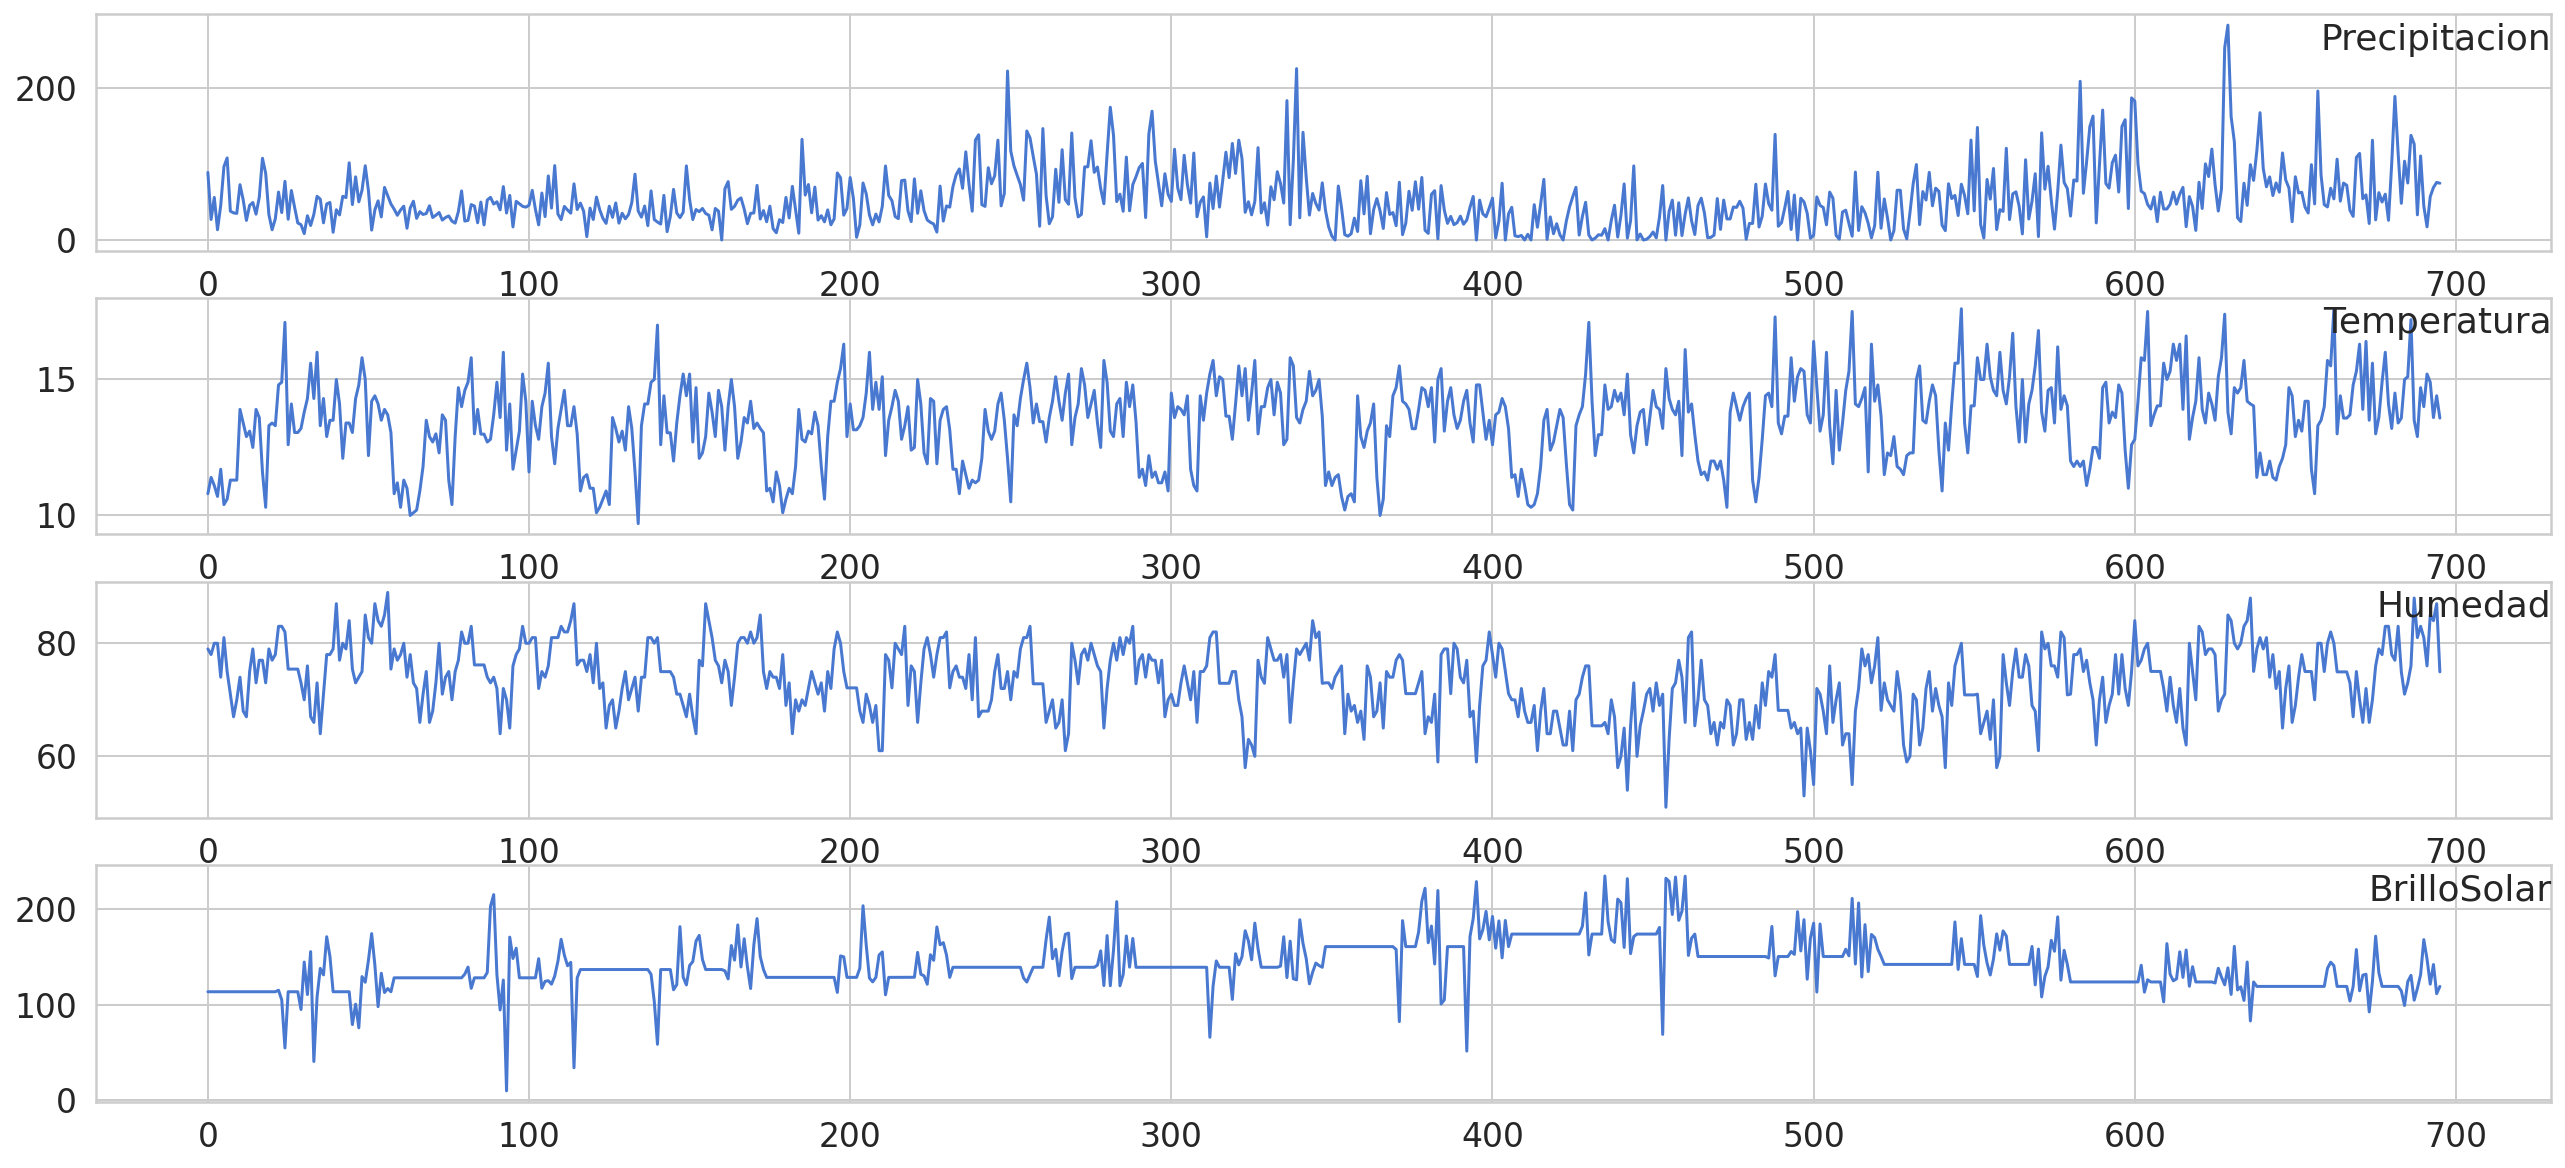

In [ ]:
#graphics station
#################graphics properties####################################
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 22, 10
#################graphics properties####################################

df_graphic_station = df_est
#df_graphic_station = df_dic


#df_graphic_station = df.copy()

val = df_graphic_station.values
features = [3,4,5,6]

i =1
plt.figure()
for feature in features:
    plt.subplot(len(features),1,i)
    plt.plot(val[:,feature])
    plt.title(df_graphic_station.columns[feature], y= 0.8 , loc = 'right')
    i += 1


In [ ]:
#Define train & test - Pick a month

#df_an = df_ene.copy()
df_an = df_est.copy()

df_an.drop('Anio', inplace=True, axis=1)
df_an.drop('Mes', inplace=True, axis=1)
df_an.drop('Estacion', inplace=True, axis=1)


#tamanio entrenamiento 80%
tam_en = int(len(df_an)*0.80)
#tamanio pruebas 20%
tam_pru = len(df_an) - tam_en

#print(len(df_an),tam_en,tam_pru)

#definir dataframes entrenamiento y pruebas
#dataframe entrenamiento [0,tamanio entrenamiento]
df_en  = df_an.iloc[0:tam_en]
#dataframe pruebas [tamanio entrenamiento,tamanio dataframe]
df_pr =  df_an.iloc[tam_en:len(df_an)]

#print('longitud dataframe entrenamiento ',len(df_en))
#print('longitud dataframe prueba ',len(df_pr))


#Normalizar caracteristicas climáticas
#https://machinelearningmastery.com/robust-scaler-transforms-for-machine-learning/
from sklearn.preprocessing import RobustScaler

#caracteristicas climaticas
caract_col = ['Temperatura','Humedad','BrilloSolar']
caract_transformer = RobustScaler()
preci_transformer = RobustScaler()

caract_transformer = caract_transformer.fit(df_en[caract_col].to_numpy())
preci_transformer = preci_transformer.fit(df_en[['Precipitacion']])

#print(caract_transformer,preci_transformer)

#asignar transformadores  dataset entrenamiento
df_en.loc[:,caract_col] = caract_transformer.transform(df_en[caract_col].to_numpy())
df_en['Precipitacion'] = preci_transformer.transform(df_en[['Precipitacion']])

#asignar transformadores dataset pruebas
df_pr.loc[:,caract_col] = caract_transformer.transform(df_pr[caract_col].to_numpy())
df_pr['Precipitacion'] = preci_transformer.transform(df_pr[['Precipitacion']])



#references
#https://www.learnpython.org/es/Loops
#https://www.analyticslane.com/2019/06/21/seleccionar-filas-y-columnas-en-pandas-con-iloc-y-loc/
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.values.html

# crear secuencia 
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)


time_steps = 2

# secuencias entrenamiento
x_en,y_en = create_dataset(df_en,df_en.Precipitacion,time_steps)

# secuencias pruebas
x_pr,y_pr = create_dataset(df_pr,df_pr.Precipitacion,time_steps)



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/lo

In [ ]:
# construccion modelo prediccion

modelo = keras.Sequential()

modelo.add
(
             keras.layers.Bidirectional(
             keras.layers.LSTM(units = 128, 
                               input_shape=(x_en.shape[1],x_en.shape[2]))  
            )
)

modelo.add(keras.layers.Dropout(rate=0.2))
modelo.add(keras.layers.Dense(units=2)) 
modelo.compile(loss='mean_squared_error', optimizer='adam')

history = modelo.fit(
    x_en, y_en, 
    epochs=30, 
    #batch_size=2, 
    batch_size=2, 
    validation_split=0.1,
    shuffle=False
)


#################graphics properties####################################
%matplotlib inline
%config InlineBackend.figure_format='retina'
register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 20, 8
#################graphics properties####################################

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Prueba')
plt.legend();


NameError: ignored

In [ ]:
y_pred = modelo.predict(x_pr)


NameError: ignored

In [ ]:
y_en_inv = preci_transformer.inverse_transform(y_en.reshape(1, -1))
y_pr_inv = preci_transformer.inverse_transform(y_pr.reshape(1, -1))
y_pred_inv = preci_transformer.inverse_transform(y_pred)

ValueError: ignored